# 安徽安庆市项目`WRF-CMAQ`模拟分析
## Model Evaluation : `meteo-obs data temperature`

---
*@author: Evan*\
*@date: 2023-03-28*

In [1]:
import ModelEvaLib as me

import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
import shapely.geometry as sgeom
from shapely.prepared import prep
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.pyplot as plt

# silence the warning note
import warnings
warnings.filterwarnings("ignore")

In [2]:
def polygon_to_mask(polygon, x, y):
    '''
    Generate a mask array of points falling into the polygon
    '''
    x = np.atleast_1d(x)
    y = np.atleast_1d(y)
    mask = np.zeros(x.shape, dtype=bool)

    # if each point falls into a polygon, without boundaries
    prepared = prep(polygon)
    for index in np.ndindex(x.shape):
        point = sgeom.Point(x[index], y[index])
        if prepared.contains(point):
            mask[index] = True

    return mask

In [4]:
ncfile = 'F:/Data/case_anqing/compressed_met.nc'
shpfile = 'F:/Data/case_anqing/shapefile/Anqing/Anqing.shp'
shpurban = 'F:/Data/case_anqing/shapefile/Anqing_urban/urban.shp'
shprural = 'F:/Data/case_anqing/shapefile//Anqing_rural/rural.shp'
xlsfile = 'F:/Data/case_anqing/obs_202302_fromlzj/allsite.xlsx'
xlsurban = 'F:/Data/case_anqing/obs_202302_fromlzj/urban.xlsx'
xlsrural = 'F:/Data/case_anqing/obs_202302_fromlzj/rural.xlsx'

title = 'WS10'
units = 'm/s'

## 安庆市全部

In [13]:
simfile = xr.open_dataset(ncfile)

uwind = simfile.uwind[:,0,:,:]
vwind = simfile.vwind[:,0,:,:]

windspeed = np.sqrt(uwind**2+vwind**2)

shp = gpd.read_file(shpurban)
for i in range(np.size(uwind.latitude,0)):
    for j in range(np.size(uwind.latitude,1)):
        if polygon_to_mask(shp.geometry[0],uwind.longitude[i,j],uwind.latitude[i,j])==False:
            windspeed[:,i,j] = np.nan

ws = np.nanmean(np.nanmean(windspeed,1),1)

In [14]:
obsfile = pd.read_excel(xlsfile)
obsurban = pd.read_excel(xlsurban)
obsrural = pd.read_excel(xlsrural)

# ws_obs = obsfile['风速']
ws_obs = obsurban['风速']

start = '2023-02-01T00'
end = '2023-02-28T23'
df = pd.DataFrame({'obs':ws_obs,'sim':ws},
                  index=pd.date_range(start,end,freq='h'))

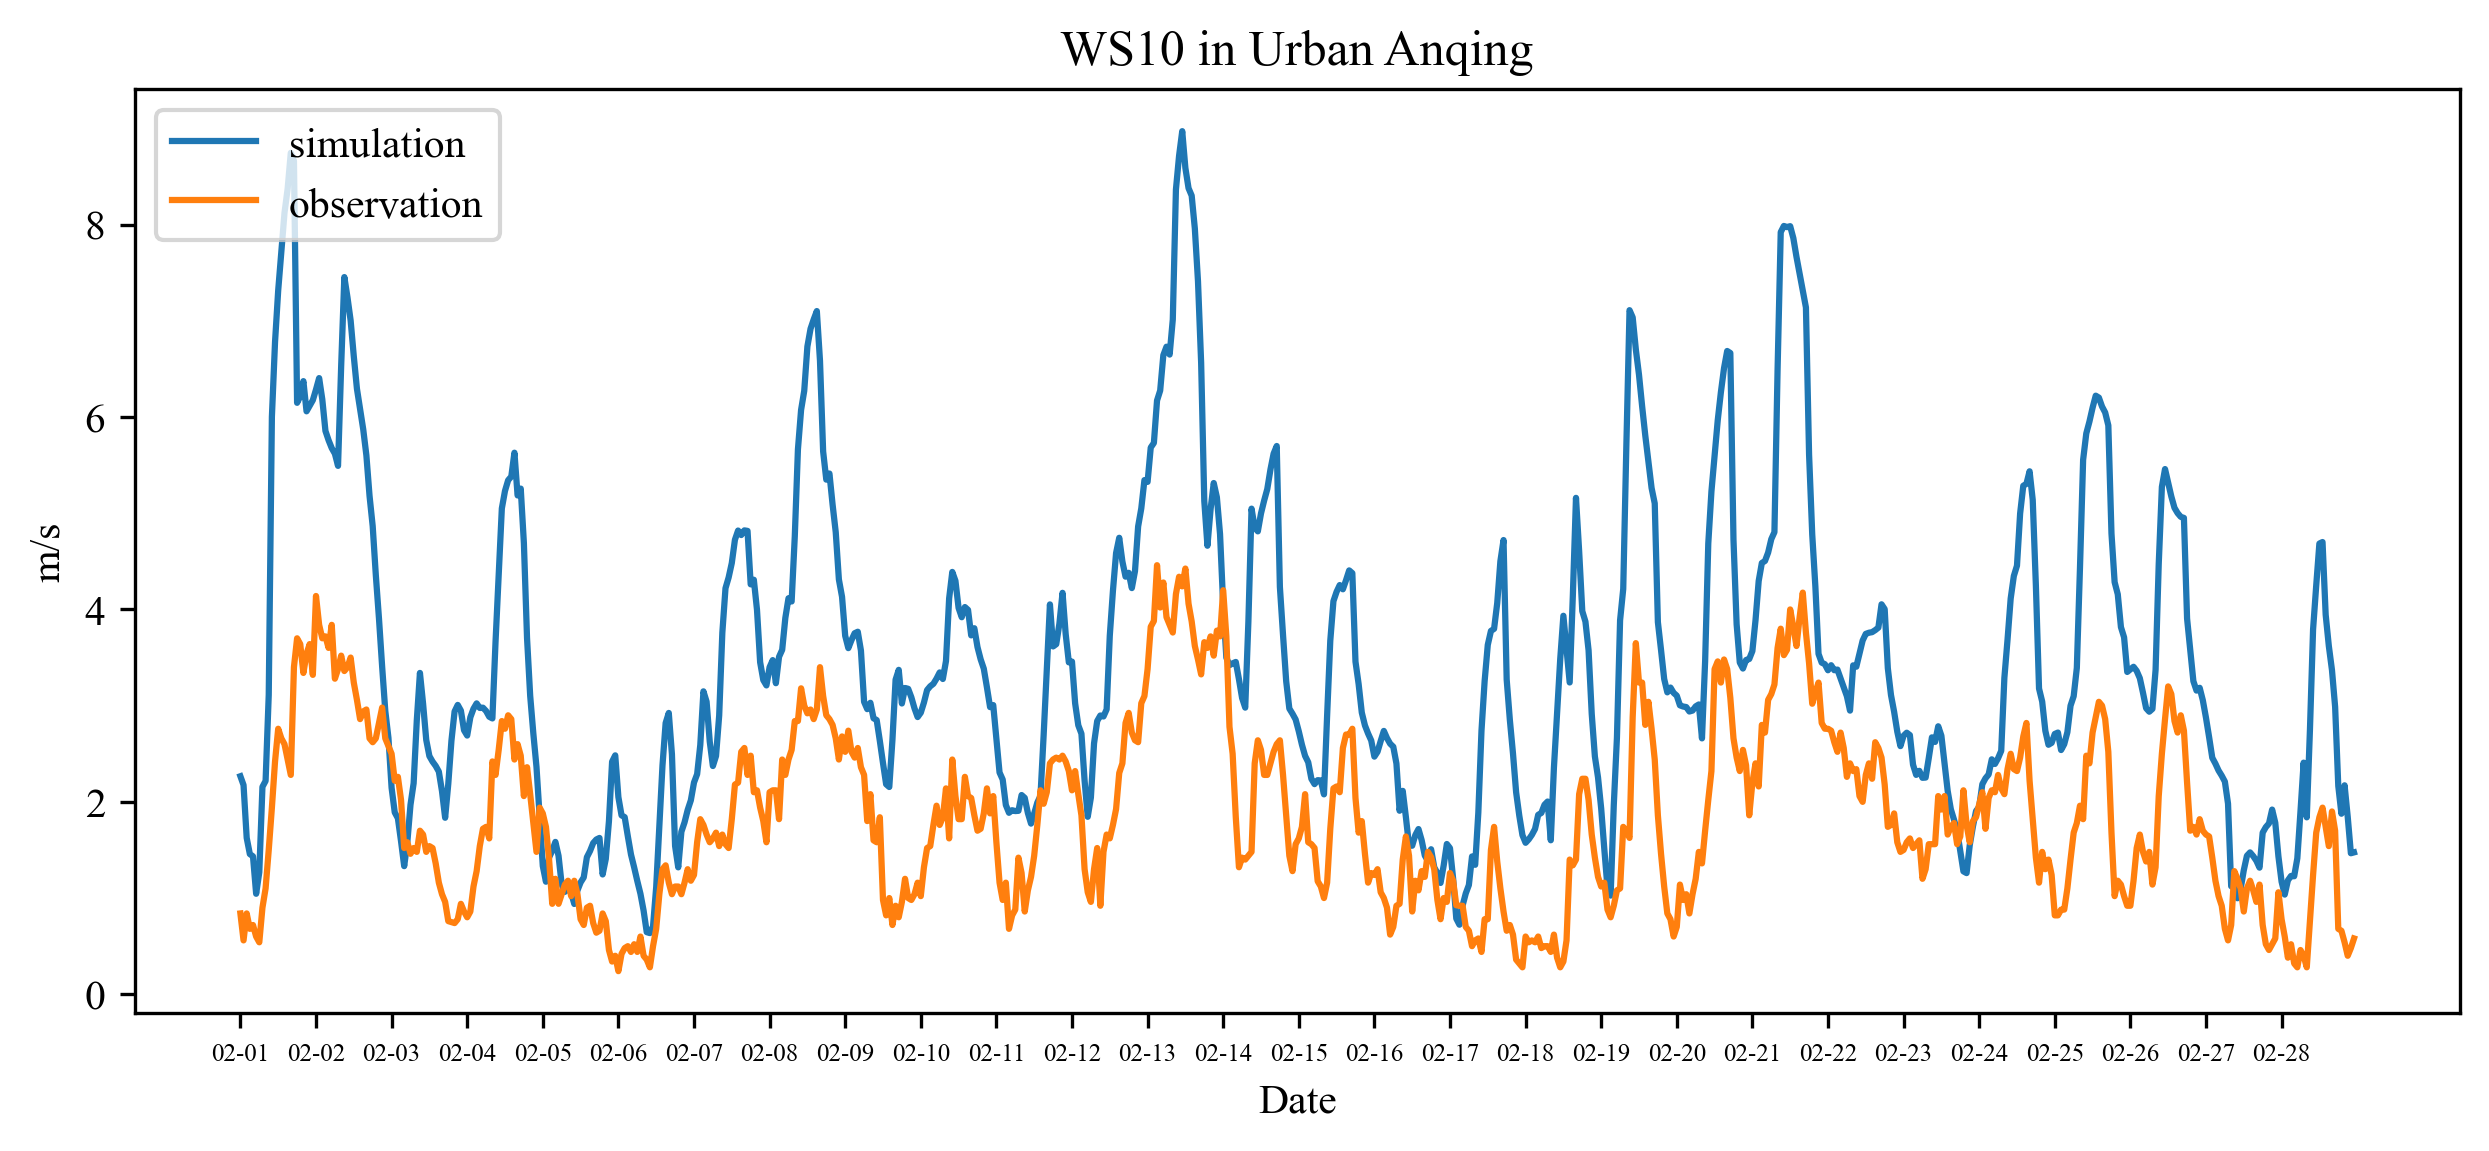

In [15]:
start = '2023-02-01T00'
end = '2023-02-28T23'

ax = me.linechart(ws, ws_obs, start, end)

ax.legend(loc=2)
ax.set_title(f'{title} in Urban Anqing')
ax.set_xlabel('Date')
ax.set_ylabel(units)
plt.show()

In [16]:
me.evaluation_frame(ws_obs, ws, df)

,param,value
0,obs mean,1.841704
1,sim mean,3.485777
2,R,NaN
3,MB,1.644073
4,RMSE,1.968668
5,IOA,0.612485
